In [1]:
import numpy as np
import random
import string
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
def generate_dictionaries(k):
    """
    Génère les dictionnaires char<->id et char<->embedding pour k lettres + un token vide.
    """
    import numpy as np

    letters = [chr(ord('A') + i) for i in range(k)]
    dim = k 
    basis = np.eye(dim)  # Embeddings orthogonaux

    char_to_id = {char: i for i, char in enumerate(letters)}
    id_to_char = {i: char for char, i in char_to_id.items()}
    char_to_embed = {char: basis[i] for i, char in enumerate(letters)}

    return char_to_id, id_to_char, char_to_embed

In [3]:
def generate_sequences(n, T, k):
    assert 1 <= k <= 26, "k doit être entre 1 et 26"
    alphabet = list(string.ascii_uppercase[:k])
    sequences = [random.choices(alphabet, k=T) for _ in range(n)]
    return sequences


In [4]:
def generate_dataset(n, T, D, seed=None):
    """
    Génère un dataset où chaque lettre après un 'A' (sauf le premier) est remplacée par
    celle qui suit le premier 'A'. Ex: [C, A, B, A, C] -> [C, A, B, A, B]
    """

    if seed is not None:
        np.random.seed(seed)

    # Dictionnaires et embeddings
    char_to_id, id_to_char, char_to_embed = generate_dictionaries(D)
    letters = [chr(ord('A') + i) for i in range(D)]

    X = []
    y = []

    sequences = generate_sequences(n, T, D)
    print(char_to_embed)

    for seq in sequences:
        embeddings = [char_to_embed[char] for char in seq]
        X.append(embeddings)

        seq_out = seq.copy()

        # Trouver tous les indices de 'A'
        A_indices = [i for i, c in enumerate(seq) if c == 'A']
        
        if len(A_indices) >= 2 and A_indices[0] + 1 < T:
            substitute_char = seq[A_indices[0] + 1]
            for idx in A_indices[1:]:
                if idx + 1 < T:
                    seq_out[idx + 1] = substitute_char

        class_ids = [char_to_id[c] for c in seq_out]
        y.append(class_ids)

    X = torch.tensor(X).float()    # [B, T, D]
    y = torch.tensor(y).long()     # [B, T]
    return X, y, char_to_id, id_to_char


In [5]:
n = 100000
T = 25
D = 3

In [6]:
X, y, char_to_id, id_to_char = generate_dataset(n, T, D)

{'A': array([1., 0., 0.]), 'B': array([0., 1., 0.]), 'C': array([0., 0., 1.])}


/tmp/ipykernel_1850729/2662916457.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  X = torch.tensor(X).float()    # [B, T, D]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)  # [1, max_len, d_model]

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)].to(x.device)
        return x

In [9]:
def token_accuracy(preds, targets):
    """
    Calcule l'accuracy lettre par lettre (token par token).
    """
    pred_classes = torch.argmax(preds, dim=-1)  # [B, T]
    correct = (pred_classes == targets).float()
    return correct.mean().item()

def train_model(model, train_loader, test_loader, epochs=10, lr=1e-3, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()  # attente [B, C, T] vs [B, T]

    train_loss_list = []
    test_loss_list = []
    test_acc_list = []

    for epoch in range(1, epochs + 1):
        model.train()
        total_train_loss = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)  # xb: [B, T, D], yb: [B, T]
            preds = model(xb)                      # preds: [B, T, C]
            preds = preds.permute(0, 2, 1)         # -> [B, C, T] pour CrossEntropy
            loss = criterion(preds, yb)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_list.append(loss.item())
            total_train_loss += loss.item()

        # 🔍 Validation à la fin de l'epoch
        model.eval()
        total_val_loss = 0
        total_acc = 0
        total_samples = 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_loss = criterion(preds.permute(0, 2, 1), yb)
                total_val_loss += val_loss.item()
                test_loss_list.append(val_loss.item())

                acc = token_accuracy(preds, yb)
                total_acc += acc * xb.size(0)
                total_samples += xb.size(0)

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(test_loader)
        avg_val_acc = total_acc / total_samples
        test_acc_list.append(avg_val_acc)

        print(f"Epoch {epoch}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f}")

    return train_loss_list, test_loss_list, test_acc_list



In [10]:
class AttentionOnlyBlock(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.Wq = nn.Linear(d_model, d_model, bias=False)
        self.Wk = nn.Linear(d_model, d_model, bias=False)
        self.Wv = nn.Linear(d_model, d_model, bias=False)
        self.norm = nn.LayerNorm(d_model)
        self.attn_weights = None  # <-- pour garder la dernière attention

    def forward(self, x):
        Q = self.Wq(x)
        K = self.Wk(x)
        V = self.Wv(x)
        attn_scores = torch.matmul(Q, Q.transpose(-2, -1)) / (Q.size(-1) ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        self.attn_weights = attn_weights.detach().cpu()  # stocker pour affichage

        attn_output = torch.matmul(attn_weights, V)
        return self.norm(attn_output + x)

class AttentionOnlyTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=128, num_layers=2, max_len=100):
        super().__init__()
        self.embedding_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([AttentionOnlyBlock(d_model) for _ in range(num_layers)])
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding_proj(x)
        x = self.pos_encoder(x)
        for layer in self.layers:
            x = layer(x)
        return self.classifier(x)

In [19]:
model = AttentionOnlyTransformer(input_dim=D, num_classes=len(char_to_id), d_model=256, num_layers=2, max_len=T)

In [15]:
# Nouveau modèle avec 4 lettres (donc input_dim = 4)
new_input_dim = D
model_new = AttentionOnlyTransformer(input_dim=new_input_dim, d_model=256, num_layers=2, num_classes=new_input_dim)
model_new.to(device)

# Charger les poids du modèle entraîné avec 3 lettres
pretrained_state = torch.load("models/model.pth")

# Charger seulement les poids compatibles (couches d'attention)
model_dict = model_new.state_dict()
for name in model_dict:
    if name.startswith('layers.') and name in pretrained_state:
        model_dict[name] = pretrained_state[name]

# Charger les poids modifiés dans le nouveau modèle
model_new.load_state_dict(model_dict)

# Geler les couches d'attention
for name, param in model_new.named_parameters():
    if name.startswith('layers.'):
        param.requires_grad = False

# Maintenant tu peux entraîner model_new comme d’habitude, avec 4 lettres


In [22]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Création des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [280]:
for name, param in model_new.named_parameters():
    if name.startswith('layers.'):
        param.requires_grad = True


In [20]:
model.load_state_dict(pretrained_state)

<All keys matched successfully>

In [23]:
train_loss_list, test_loss_list, test_acc_list = train_model(model, train_loader, test_loader, epochs=10, lr=0.0001, device=device)

Epoch 1/10 | Train Loss: 0.0002 | Val Loss: 0.0000 | Val Acc: 1.0000


KeyboardInterrupt: 

In [28]:
torch.save(model.state_dict(), "models/model.pth")

In [24]:
def show_colored_predictions_on_dataset(model, X, y, id_to_char, char_to_id, max_samples=5, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Affiche les prédictions du modèle sur un dataset donné (X, y).
    Colore en vert les bonnes prédictions, en rouge les erreurs.
    Affiche aussi la lettre à utiliser pour les remplacements après les 'A'.
    
    Args:
        model: le modèle entraîné
        X: tenseur [B, T, D]
        y: tenseur [B, T]
        id_to_char: dictionnaire id -> lettre
        char_to_id: dictionnaire lettre -> id
        max_samples: nombre de séquences à afficher
    """
    model.eval()
    with torch.no_grad():
        X = X.to(device)
        y = y.to(device)
        preds = torch.argmax(model(X), dim=-1)  # [B, T]

    for i in range(min(max_samples, X.shape[0])):
        x_ids = torch.argmax(X[i], dim=-1).cpu().numpy()
        input_seq = [id_to_char[idx] for idx in x_ids]
        true_seq = [id_to_char[idx] for idx in y[i].cpu().numpy()]
        pred_seq = [id_to_char[idx] for idx in preds[i].cpu().numpy()]

        # Trouver la lettre de remplacement après le premier 'A' s’il y a lieu
        A_indices = [j for j, c in enumerate(input_seq) if c == 'A']
        substitution_letter = "-"
        if len(A_indices) >= 2 and A_indices[0] + 1 < len(input_seq):
            substitution_letter = input_seq[A_indices[0] + 1]

        print(f"\n🔄 Replacement letter after first 'A': {substitution_letter}")
        print("📝 Input sequence  : ", end="")
        for c in input_seq:
            print(f"{c:>3}", end="")
        print()

        print("🎯 Expected output : ", end="")
        for t, p in zip(true_seq, pred_seq):
            color = "\033[92m" if t == p else "\033[91m"
            print(f"{color}{t:>3}\033[0m", end="")
        print()

        print("🔮 Model predicts  : ", end="")
        for t, p in zip(true_seq, pred_seq):
            color = "\033[92m" if t == p else "\033[91m"
            print(f"{color}{p:>3}\033[0m", end="")
        print("\n" + "-" * 50)


In [27]:
show_colored_predictions_on_dataset(model, X_test, y_test, id_to_char, char_to_id, max_samples=20)



🔄 Replacement letter after first 'A': C
📝 Input sequence  :   A  C  C  C  A  B  B  C  A  C  B  B  B  B  B  A  A  C  C  B  B  A  A  B  B  C  A  B  C  A  C  A  B  B  C  A  B  B  B  B  C  B  B  C  A  A  C  A  A  A
🎯 Expected output :   A  C  C  C  A  C  B  C  A  C  B  B  B  B  B  A  C  C  C  B  B  A  C  C  B  C  A  C  C  A  C  A  C  B  C  A  C  B  B  B  C  B  B  C  A  C  C  A  C  C
🔮 Model predicts  :   A  C  C  C  A  C  B  C  A  C  B  B  B  B  B  A  C  C  C  B  B  A  C  C  B  C  A  C  C  A  C  A  C  B  C  A  C  B  B  B  C  B  B  C  A  C  C  A  C  C
--------------------------------------------------

🔄 Replacement letter after first 'A': A
📝 Input sequence  :   A  A  C  A  A  C  A  A  B  C  A  B  A  B  B  C  B  C  C  A  A  C  C  C  C  A  B  A  A  C  A  C  A  B  B  A  C  A  C  A  A  B  C  C  B  A  B  C  A  A
🎯 Expected output :   A  A  A  A  A  A  A  A  A  C  A  A  A  A  B  C  B  C  C  A  A  A  C  C  C  A  A  A  A  A  A  A  A  A  B  A  A  A  A  A  A  A  C  C  B  A  A  C  A  A
🔮 Model pred

In [25]:
def plot_attention_matrices_with_accuracy(model, sequences, char_to_id, special_char='A', special_value=7, device=device, n_layers=1):
    D = len(char_to_id)
    embeddings = np.eye(D)
    model.eval()

    num_sequences = len(sequences)
    fig, axs = plt.subplots(num_sequences, 2, figsize=(14, 3.5 * num_sequences))

    if num_sequences == 1:
        axs = [axs]

    for i, sequence in enumerate(sequences):
        # Embedding + entrée
        x_seq = [embeddings[char_to_id[c]] for c in sequence]
        x_tensor = torch.tensor([x_seq], dtype=torch.float32).to(device)

        # Calcul des cibles attendues
        counts = {c: sequence.count(c) for c in char_to_id}
        y_target = torch.tensor([[special_value if c == special_char else counts[c] for c in sequence]], dtype=torch.long).to(device)

        # Prédiction
        with torch.no_grad():
            preds = model(x_tensor).squeeze(0)  # [T, 1]

        k = 20

        for k_layer in range(n_layers):
            attn = F.softmax(model.layers[k_layer].attn_weights, dim=-1).detach().squeeze(0).cpu().numpy()[:k,:k]
            sns.heatmap(attn, cmap="viridis", xticklabels=sequence[:k], yticklabels=sequence[:k], square=True,
                        cbar=True, ax=axs[i][k_layer])
            axs[i][k_layer].set_title(f"Layer {k_layer + 1} ")
            axs[i][k_layer].set_xlabel("Input Sequence")
            axs[i][k_layer].set_ylabel("Attention Weights")
            axs[i][k_layer].set_xticklabels(sequence[:k], rotation=45)
            axs[i][k_layer].set_yticklabels(sequence[:k], rotation=0)




    plt.tight_layout()
    plt.show()
    return fig

In [26]:
def decode_x_to_letters(x_tensor, id_to_char):
    """
    Convertit un tenseur [B, T, D] en liste de séquences de lettres.

    Args:
        x_tensor: tenseur de taille [B, T, D] (one-hot ou proche de one-hot)
        id_to_char: dictionnaire id -> lettre (ex: {0: 'A', 1: 'B', ...})

    Returns:
        List[str]: liste de chaînes de lettres, une par séquence du batch.
    """
    x_ids = torch.argmax(x_tensor, dim=-1).cpu().numpy()  # [B, T]
    sequences = []
    for row in x_ids:
        letters = [id_to_char[i] for i in row]
        sequences.append("".join(letters))
    return sequences


In [27]:
sequences = decode_x_to_letters(X_test[:5], id_to_char)

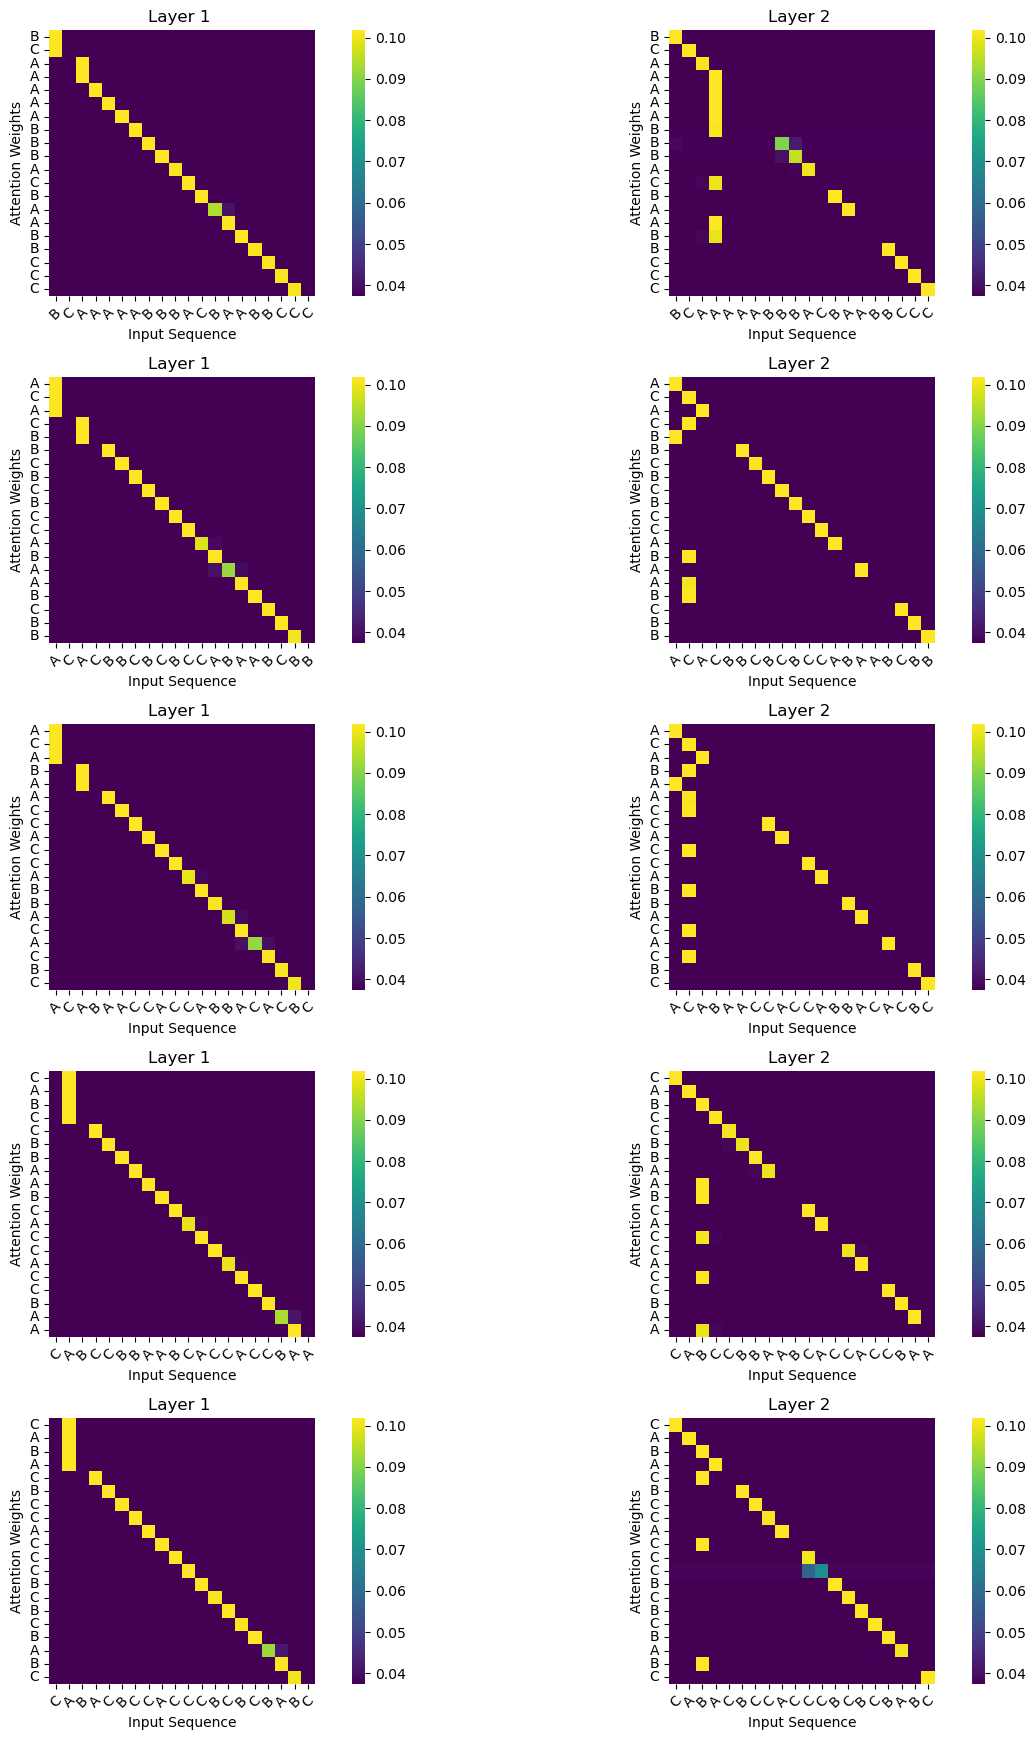

In [28]:
fig = plot_attention_matrices_with_accuracy(model, sequences, char_to_id, special_char='A', special_value=7, device=device, n_layers=2)

In [42]:
fig.savefig("images/attention_matrices_2layers_3letters2.png", dpi=300, bbox_inches='tight')

In [34]:
import torch
import torch.nn.functional as F

T = 4
scores = torch.full((T, T), -float(0))  # -inf partout
for i in range(T):
    if i == 0:
        scores[i, 0] = 3  # force attention sur (0,0)
    else:
        scores[i, i-1] = 3  # force attention sur la sous-diagonale

print(scores)
attn_weights = F.softmax(scores, dim=-1)
print(attn_weights)


tensor([[3., -0., -0., -0.],
        [3., -0., -0., -0.],
        [-0., 3., -0., -0.],
        [-0., -0., 3., -0.]])
tensor([[0.8700, 0.0433, 0.0433, 0.0433],
        [0.8700, 0.0433, 0.0433, 0.0433],
        [0.0433, 0.8700, 0.0433, 0.0433],
        [0.0433, 0.0433, 0.8700, 0.0433]])


In [35]:
E = model.embedding_proj.weight.data.T    # shape (k, d_model)

In [33]:
seq = np.eye(3)
seq

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [36]:
layer = model.layers[0]  # choisir la couche

WQ = layer.Wq.weight.data
WK = layer.Wk.weight.data
WV = layer.Wv.weight.data

QK = torch.matmul(WQ.t(), WK)  # d_model x d_model
OV = WV                        # d_model x d_model

E = model.embedding_proj.weight.data.T  # k x d_model

# Matrices contextualisées dans l'espace des tokens
QK_tokens = E @ QK @ E.T   # k x k
OV_tokens = E @ OV @ E.T   # k x k


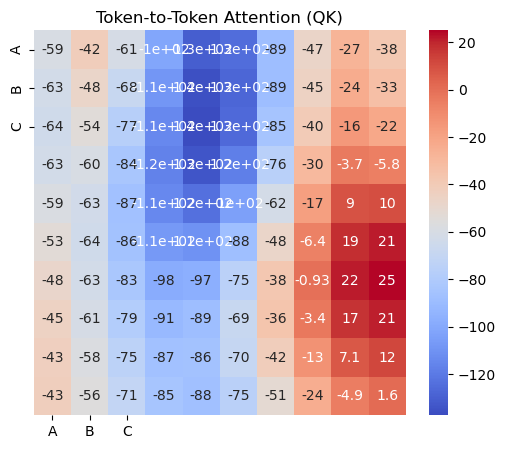

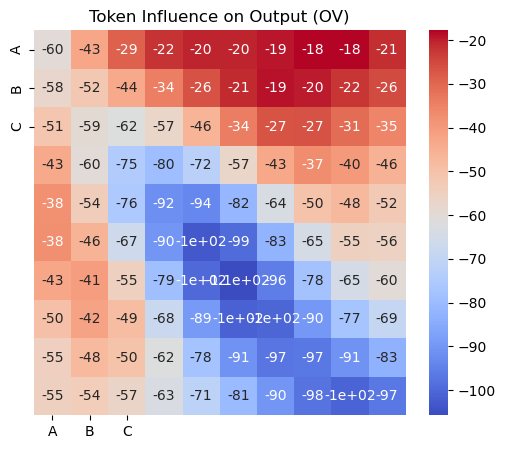

In [42]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que tu as accès à ton modèle et à ton embedding projection
layer = model.layers[0]

# Récupérer les poids
WQ = layer.Wq.weight.data
WK = layer.Wk.weight.data
WV = layer.Wv.weight.data

QK = torch.matmul(WQ.t(), WK)  # d_model x d_model
OV = WV                        # d_model x d_model

positions = torch.arange(10)  # [0, 1, 2] si k=3

# Embeddings positionnels pour ces positions
E = model.pos_encoder.pe.squeeze(0)[positions].to(device)  # (k, d_model)



# Matrices contextualisées dans l'espace des tokens
QK_tokens = E @ QK @ E.T   # k x k
OV_tokens = E @ OV @ E.T   # k x k

# Afficher QK avec Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(QK_tokens.cpu().numpy(), annot=True, cmap="coolwarm", xticklabels=["A", "B", "C"], yticklabels=["A", "B", "C"])
plt.title("Token-to-Token Attention (QK)")
plt.show()

# Afficher OV avec Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(OV_tokens.cpu().numpy(), annot=True, cmap="coolwarm", xticklabels=["A", "B", "C"], yticklabels=["A", "B", "C"])
plt.title("Token Influence on Output (OV)")
plt.show()
